In [ ]:
# Import necessary libraries
import numpy as np
import seaborn as sns
import optuna
from optuna.trial import TrialState
from parse_logfile import TextLog
import pipeline_MSLR as pipln
import pandas as pd
import seaborn as sns
import warnings
import BehavUtils as butils
import glob
from natsort import natsorted
import time
import reaction_time as reac
from jax.config import config
import os
import acme
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# Enable 64-bit precision in JAX
config.update("jax_enable_x64", True)

# Set seaborn plot style and ignore warnings
sns.set_style('white')
warnings.filterwarnings(action='ignore', message='Mean of empty slice')
warnings.filterwarnings(action='ignore', message='Degrees of freedom <= 0 for slice')
warnings.filterwarnings(action='ignore', message='All-NaN slice encountered')
warnings.filterwarnings(action='ignore', message='RuntimeWarning: invalid value encountered in double_scalars')
np.seterr(over='ignore')

# Define the animal
animal = 'mouse'

# Load log, flash, face, and eye files
with open('RawData/Mouse/files_logs_mouse_moreSes.txt') as f:
    files_logs = [line.strip() for line in f.readlines()]
with open('RawData/Mouse/files_flashes_mouse_moreSes.txt') as f:
    files_flashes = [line.strip() for line in f.readlines()]
with open('RawData/Mouse/files_face_mouse_moreSes_updated.txt') as f:
    files_face = [line.strip() for line in f.readlines()]
with open('RawData/Mouse/files_eye_mouse_moreSes_updated.txt') as f:
    files_eye = [line.strip() for line in f.readlines()]

# Define which column names to read from the face and eye files
with open('RawData/Mouse/cols_nose_updated.txt') as f:
    cols_nose = [line.strip() for line in f.readlines()]
with open('RawData/Mouse/cols_whiskers_updated.txt') as f:
    cols_whiskers = [line.strip() for line in f.readlines()]
with open('RawData/Mouse/cols_eye.txt') as f:
    cols_eye = [line.strip() for line in f.readlines()]

# Define parameters for cross-validation, repetitions, and data splitting
nWindows = 5
nRepetitions = 5
nSplits = 5
btscv = butils.BlockingTimeSeriesSplit(n_splits=nSplits)
shiftStim = -0.25
winSize = 0.25
internal_states = np.arange(2, 16)

# Define how many partitions to use for Dask loading in the data.
nPartitions = os.cpu_count() - 2

# Clean up the cluster and set up a new cluster client
acme.cluster_cleanup()
client = acme.esi_cluster_setup(partition="8GBXS", n_jobs=int(nSplits),
                                n_jobs_startup=2, timeout=60000, interactive_wait=1)

start1 = time.time()

# Define session indices for each mouse
mouse_1 = np.array([15,16,17,18,19,20,21,22,23,24,25,26])
mouse_2 = np.array([0,1,2,3])
mouse_3 = np.array([4,5,6,7,27,28])
mouse_4 = np.array([8,9,10])
mouse_5 = np.array([11,12])
mouse_6 = np.setdiff1d(np.arange(len(files_logs)), np.concatenate([mouse_1, mouse_2, mouse_3, mouse_4, mouse_5]))

# Organize mouse sessions into a dictionary for easy access
mouse_sessions = {
    'mouse_1': mouse_1,
    'mouse_2': mouse_2,
    'mouse_3': mouse_3,
    'mouse_4': mouse_4,
    'mouse_5': mouse_5,
    'mouse_6': mouse_6
}

# Initialize dictionaries to store training and testing data for each mouse
mouse_data = {
    mouse: {
        'dat_train_list': [],
        'dat_test_list': [],
        'y_train_list': [],
        'y_test_list': []
    } for mouse in mouse_sessions
}

# Function to determine which mouse a session belongs to
def get_mouse_label(session_idx):
    for mouse_label, sessions in mouse_sessions.items():
        if session_idx in sessions:
            return mouse_label
    return None  # In case a session doesn't belong to any mouse

# Iterate over all sessions
for rr in range(len(files_logs)):

    # Determine which mouse this session belongs to
    mouse_label = get_mouse_label(rr)
    if mouse_label is None:
        print(f"Session {rr} does not belong to any defined mouse. Skipping.")
        continue  # Skip sessions that don't belong to any mouse

    # Load flashes data
    flashes = np.load(files_flashes[rr], allow_pickle=True)

    # Parse event markers from log file
    evt, newSamp, nPoints, t_final, idx_start, idx_stim, _ = butils.readLog(files_logs[rr], 'mouse')

    # Process session data, reaction times, and rescale reaction times
    sess_data = reac.sess_data_maker(files_logs[rr], animal, 3000)
    r_time, _ = reac.reaction_time(sess_data, [5,10,15])
    r_time[pd.isna(r_time)] = -1
    r_time = r_time.astype(np.float64)
    r_time = r_time / newSamp
    r_time[r_time > 4] = 4

    t_tmp = np.nan * np.ones(nPoints)
    t_tmp[idx_start[:-1]] = flashes[:-1]
    frames_dlc = pd.Series(t_tmp).interpolate(method="linear").values
    frames_dlc[np.isnan(frames_dlc)] = 0
    frames_dlc = np.array(frames_dlc, dtype=int)

    t_stim = np.unique(t_final[idx_stim])

    # Load facial and eye data using Dask
    dat_face = butils.daskLoadCSV(files_face[rr], cols_nose, nPartitions=nPartitions)
    dat_whis = butils.daskLoadCSV(files_face[rr], cols_whiskers, nPartitions=nPartitions)
    dat_eye = butils.daskLoadCSV(files_eye[rr], cols_eye, nPartitions=nPartitions)

    # Calculate positions and sizes
    nose_x_fin, nose_y_fin, _ = butils.dlcCalcs(dat_face, nPoints=frames_dlc.shape[0], doSize=0)
    eye_x_fin, eye_y_fin, pupSize_t = butils.dlcCalcs(dat_eye, nPoints=frames_dlc.shape[0], doSize=1)
    whisk_x_fin, whisk_y_fin, _ = butils.dlcCalcs(dat_whis, nPoints=frames_dlc.shape[0], doSize=0)

    # Prepare predictors
    predVar = [eye_x_fin, eye_y_fin, nose_x_fin, nose_y_fin, whisk_x_fin, whisk_y_fin]
    predictors = butils.preprocess_data(predVar, pupSize_t, eye_x_fin, eye_y_fin, t_final, idx_start, t_stim, animal, shiftStim, winSize)

    # Ensure predictors and reaction times have the same length
    if predictors.shape[0] > r_time.shape[0]:
        predictors = predictors[:-1,:]
    elif predictors.shape[0] < r_time.shape[0]:
        r_time = r_time[:-1]

    # Split data into training and testing sets
    size = int(len(r_time) * 0.8)
    dat_train, dat_test, y_train, y_test = predictors[:size,:], predictors[size:,:], r_time[:size], r_time[size:]
    estimator = BayesianRidge()

    # Impute missing values in training data
    imp = IterativeImputer(estimator=estimator, random_state=42, max_iter=100, sample_posterior=True, skip_complete=True)
    dat_train = imp.fit_transform(dat_train)
    y_train = y_train.reshape(-1,1)

    # Append the processed data to the corresponding mouse's lists
    mouse_data[mouse_label]['dat_train_list'].append(dat_train)
    mouse_data[mouse_label]['dat_test_list'].append(dat_test)
    mouse_data[mouse_label]['y_train_list'].append(y_train)
    mouse_data[mouse_label]['y_test_list'].append(y_test)

# After processing all sessions, concatenate data separately for each mouse
dat_train_final = {}
dat_test_final = {}
y_train_final = {}
y_test_final = {}

for mouse_label, data in mouse_data.items():
    # Concatenate training and testing data
    dat_train_final[mouse_label] = butils.pad_concatenate(data['dat_train_list'], doEmissions=False, numPad=20)
    y_train_final[mouse_label] = butils.pad_concatenate(data['y_train_list'], doEmissions=True, numPad=20)

# ================================
# ======= Saving the Data ========
# ================================

# Define the directory to save the processed data
save_dir = 'RawData/Mouse/'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save the concatenated training data per mouse
train_save_path = os.path.join(save_dir, 'Predictors_emissions_train_per_mouse_generalisation_20pad.npz')
np.savez(
    train_save_path,
    dat_train_final=dat_train_final,
    y_train_final=y_train_final
)
print(f"Training data per mouse saved to {train_save_path}")
end1 = time.time()
print(f"Data processing and saving completed in {np.round(end1 - start1, 2)} seconds.")


<ParallelMap> WARNING: <cluster_cleanup> No dangling clients or clusters found.


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39957 instead
  warnings.warn(
<ParallelMap> INFO: <slurm_cluster_setup> Requested job-count 5 exceeds `n_jobs_startup`: waiting for 2 jobs to come online, then proceed
INFO:<ParallelMap>:<slurm_cluster_setup> Requested job-count 5 exceeds `n_jobs_startup`: waiting for 2 jobs to come online, then proceed
<slurm_cluster_setup> SLURM workers ready: 5/None 	[elapsed time 00:11 | timeout at :40:00]
<ParallelMap> INFO: <slurm_cluster_setup> Cluster dashboard accessible at http://10.100.32.3:39957/status
INFO:<ParallelMap>:<slurm_cluster_setup> Cluster dashboard accessible at http://10.100.32.3:39957/status


N frames missed: 22
GFrameNumber does not match first PresentCount, automatically adjusting
AnimalCharacter_C_2147482442
N frames missed: 22
GFrameNumber does not match first PresentCount, automatically adjusting


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 34
AnimalCharacter_C_2147482442
N frames missed: 34


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 20
AnimalCharacter_C_2147482442
N frames missed: 20


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 23
AnimalCharacter_C_2147482442
N frames missed: 23


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 25
AnimalCharacter_C_2147482442
N frames missed: 25


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 43
AnimalCharacter_C_2147482442
N frames missed: 43


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 24
AnimalCharacter_C_2147482442
N frames missed: 24


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 23
AnimalCharacter_C_2147482443
N frames missed: 23


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 10
AnimalCharacter_C_2147482442
N frames missed: 10


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 14
AnimalCharacter_C_2147482442
N frames missed: 14


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 2
AnimalCharacter_C_2147482442
N frames missed: 2


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 13
AnimalCharacter_C_2147482443
N frames missed: 13


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 24
AnimalCharacter_C_2147482442
N frames missed: 24


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 5
AnimalCharacter_C_2147482442
N frames missed: 5


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 11
AnimalCharacter_C_2147482442
N frames missed: 11


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 10
AnimalCharacter_C_2147482443
N frames missed: 10


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 12
AnimalCharacter_C_2147482442
N frames missed: 12


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 8
AnimalCharacter_C_2147482442
N frames missed: 8


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 15
AnimalCharacter_C_2147482443
N frames missed: 15


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 26
GFrameNumber does not match first PresentCount, automatically adjusting
AnimalCharacter_C_2147482443
N frames missed: 26
GFrameNumber does not match first PresentCount, automatically adjusting


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 16
AnimalCharacter_C_2147482443
N frames missed: 16


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 19
AnimalCharacter_C_2147482442
N frames missed: 19


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 32
AnimalCharacter_C_2147482440
N frames missed: 32


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 14
AnimalCharacter_C_2147482440
N frames missed: 14


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 6
AnimalCharacter_C_2147482443
N frames missed: 6


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 20
AnimalCharacter_C_2147482443
N frames missed: 20


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 14
AnimalCharacter_C_2147482442
N frames missed: 14


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 23
AnimalCharacter_C_2147482443
N frames missed: 23


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 24
AnimalCharacter_C_2147482442
N frames missed: 24


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

Training data per mouse saved to RawData/Mouse/Predictors_emissions_train_per_mouse_generalisation_20pad.npz
Data processing and saving completed in 948.85 seconds.


In [ ]:
# Import necessary libraries
import numpy as np
import optuna
import pipeline_MSLR as pipln
import warnings
import BehavUtils as butils
import time
from jax.config import config
import os
import acme
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score  # For computing R² scores
from collections import defaultdict  # For aggregating R² scores

# Enable 64-bit precision in JAX
config.update("jax_enable_x64", True)

# Ignore specific warnings to keep the output clean
warnings.filterwarnings(action='ignore', message='Mean of empty slice')
warnings.filterwarnings(action='ignore', message='Degrees of freedom <= 0 for slice')
warnings.filterwarnings(action='ignore', message='All-NaN slice encountered')
warnings.filterwarnings(action='ignore', message='RuntimeWarning: invalid value encountered in double_scalars')
np.seterr(over='ignore')

# Define the animal type
animal = 'mouse'

date = '14112024'

# Load log, flash, face, and eye files
with open('RawData/Mouse/files_logs_mouse_moreSes.txt') as f:
    files_logs = [line.strip() for line in f.readlines()]

# Define parameters for cross-validation, repetitions, and data splitting
nWindows = 5
nRepetitions = 5
nSplits = 5
btscv = butils.BlockingTimeSeriesSplit(n_splits=nSplits)
shiftStim = -0.25
winSize = 0.25
internal_states = np.arange(2, 16)  # Range of internal states to evaluate

# Define how many partitions to use for Dask loading in the data
nPartitions = os.cpu_count() - 2

selected_states = 3

# Clean up the cluster and set up a new cluster client
acme.cluster_cleanup()
client = acme.esi_cluster_setup(partition="8GBXS", n_jobs=int(nSplits),
                                n_jobs_startup=2, timeout=60000, interactive_wait=1)

# Start overall timing
start1 = time.time()

# Define session indices for each mouse
mouse_1 = np.array([15,16,17,18,19,20,21,22,23,24,25,26])
mouse_2 = np.array([0,1,2,3])
mouse_3 = np.array([4,5,6,7,27,28])
mouse_4 = np.array([8,9,10])
mouse_5 = np.array([11,12])
mouse_6 = np.setdiff1d(np.arange(len(files_logs)), 
                        np.concatenate([mouse_1, mouse_2, mouse_3, mouse_4, mouse_5]))

# Organize mouse sessions into a dictionary for easy access
mouse_sessions = {
    'mouse_1': mouse_1,
    'mouse_2': mouse_2,
    'mouse_3': mouse_3,
    'mouse_4': mouse_4,
    'mouse_5': mouse_5,
    'mouse_6': mouse_6
}

# List of mouse labels for iteration
mouse_labels = list(mouse_sessions.keys())

variables_mouse = np.array(['Pupil Size', 'Eye Mov', 'Nose Mov', 'Eye [x]', 'Eye [y]', 'Nose [x]', 'Nose [y]', 'Whiskers [x]', 'Whiskers [y]'])

# ================================
# ======= Loading Training Data ===
# ================================

# Load pre-concatenated training data per mouse
train_test_dir = 'RawData/Mouse/'  # Directory where processed data is saved
train_data_path = os.path.join(train_test_dir, 'Predictors_emissions_train_per_mouse_generalisation_20pad.npz')

# Verify that the training data file exists
if not os.path.exists(train_data_path):
    raise FileNotFoundError(f"Training data file not found at {train_data_path}")

# Load the training data
dat_all_train = np.load(train_data_path, allow_pickle=True)
dat_train_final = dat_all_train['dat_train_final'].item()  # Dictionary: { 'mouse_1': array, ... }
y_train_final = dat_all_train['y_train_final'].item()      # Dictionary: { 'mouse_1': array, ... }

# Clamp y_train_final to a maximum value of 4
for mouse_label in y_train_final:
    y_train_final[mouse_label] = np.clip(y_train_final[mouse_label], None, 4)

# Remove 'Eye Mov' from dat_train_final
eye_mov_idx = np.where(variables_mouse != 'Eye Mov')[0]
for mouse_label in dat_train_final:
    dat_train_final[mouse_label] = dat_train_final[mouse_label][:, eye_mov_idx]

# ================================
# ======= Loading Optuna Results ===
# ================================

# Load Optuna results (ensure this file exists and contains the necessary data)
optuna_results_path = 'Results/Mouse/Results_CV_sLDS_Optuna_mouse_100trials_3_states_28112023_RT_noEyeMovModel_AllSubjects_R2score_CVOnly.npz'
if not os.path.exists(optuna_results_path):
    raise FileNotFoundError(f"Optuna results file not found at {optuna_results_path}")

dat_optuna = np.load(optuna_results_path, allow_pickle=True)
# Extract selected concentration and stickiness
selected_concentration = dat_optuna['concentration']
selected_stickiness = dat_optuna['stickiness']

# ================================
# ======= LOO-CV Loop ============
# ================================

# Iterate over each leave-one-mouse-out fold
for held_out_mouse in mouse_labels:
    start_fold = time.time()
    print(f'\nProcessing fold: Training on all mice except {held_out_mouse}, testing on {held_out_mouse}')
    
    # Prepare training data by concatenating data from all mice except the held-out mouse
    train_dat_list = [dat_train_final[mouse] for mouse in mouse_labels if mouse != held_out_mouse]
    train_y_list = [y_train_final[mouse] for mouse in mouse_labels if mouse != held_out_mouse]
    
    # Concatenate training data and labels
    train_dat = np.concatenate(train_dat_list, axis=0)
    train_y = np.concatenate(train_y_list, axis=0).reshape(-1, 1)
    
    # Retrieve the test session indices for the held-out mouse
    test_session_indices = mouse_sessions[held_out_mouse]
    
    # Iterate through each test session individually
    for session_idx, rr in enumerate(test_session_indices):
        print(f'  Testing on session {session_idx+1} of {held_out_mouse}')
        
        # Define the test filename based on the session index
        test_filename = f'RawData/Mouse/Predictors_emissions_mouse_newDLC_test_session{rr}_nonScaled.npz'
        
        # Check if the test file exists
        if not os.path.exists(test_filename):
            print(f"    Test file {test_filename} not found. Skipping session {rr}.")
            continue  # Skip if test file does not exist
        
        # Load test session data
        dats = np.load(test_filename, allow_pickle=True)
        dat_test = dats['predictors']
        dat_test = dat_test[:, eye_mov_idx]
        
        y_test = dats['emissions']
        y_test = np.clip(y_test, None, 4)  # Clamp emissions to a maximum of 4
        
        start2 = time.time()
        
        try:
            # Initialize the MSLR model instance
            mouse_MSLR_instance = pipln.model_MSLR_concat(
                train_y,               # Training emissions
                train_dat,             # Training predictors
                y_test,                # Testing emissions for the current session
                dat_test,              # Testing predictors for the current session
                selected_states, 
                selected_concentration, 
                selected_stickiness,
                btscv,
                nRepetitions
            )
            pipln.model_MSLR_concat(y_train_final,dat_train_final,y_test,dat_test,
                                                        selected_states, selected_concentration, selected_stickiness,btscv,nRepetitions)

            # Perform testing
            _, y_pred, y_test_out, state_probabilities, most_likely_states, _, _ = mouse_MSLR_instance.test_mslr()
            
            # Compute R² score
            r2 = r2_score(y_test_out, y_pred)
            
            # Prepare results dictionary (optional: save more details if needed)
            results = {
                'predictions': y_pred,
                'y_test': y_test_out,
                'R2_score': r2,
                'state_probabilities': state_probabilities,
                'most_likely_states': most_likely_states
            }
            
            # Define the result filename
            result_filename = (
                f"Results/Mouse/Results_Test_MSLR_Optuna_mouse_{selected_states}states_leave_one_out_"
                f"{date}_RT_AllSubjects_{held_out_mouse}_session{session_idx+1}.npz"
            )
            
            # Ensure the results directory exists
            os.makedirs(os.path.dirname(result_filename), exist_ok=True)
            
            # Save the results
            np.savez(result_filename, results)
            
            print(f'      Session {session_idx+1}, selected_states={selected_states} completed in '
                    f'{np.round(time.time() - start2, 2)} seconds. R²: {r2:.4f}')
        
        except Exception as e:
            print(f"      Error processing session {session_idx+1}, state {selected_states}: {e}")
            continue  # Skip to the next iteration in case of an error

    print(f'-- Fold {held_out_mouse} completed in {np.round(time.time() - start_fold, 2)} seconds --')

# Final timing
end1 = time.time()
print('--'*20 + f' It took {np.round(end1 - start1, 3)} seconds for all folds to finish ' + '--'*20)

/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/acme/dask_helpers.py:765: RuntimeWarning: <cluster_cleanup> No dangling clients or clusters found.
  inspect.currentframe().f_lineno)


<slurm_cluster_setup> Requested job-count 5 exceeds `n_jobs_startup`: waiting for 2 jobs to come online, then proceed


<slurm_cluster_setup> SLURM workers ready: 5/None 	[elapsed time 00:21 | timeout at :40:00]


<slurm_cluster_setup> Cluster dashboard accessible at http://10.100.32.3:8787/status

Processing fold: Training on all mice except mouse_1, testing on mouse_1
  Testing on session 1 of mouse_1


(55, 8) (55, 1, 8) (55, 1)
      Session 1, selected_states=3 completed in 6.5 seconds. R²: 0.6541
  Testing on session 2 of mouse_1


(71, 8) (71, 1, 8) (71, 1)
      Session 2, selected_states=3 completed in 3.2 seconds. R²: 0.7318
  Testing on session 3 of mouse_1


(73, 8) (73, 1, 8) (73, 1)
      Session 3, selected_states=3 completed in 3.2 seconds. R²: 0.6442
  Testing on session 4 of mouse_1


(49, 8) (49, 1, 8) (49, 1)
      Session 4, selected_states=3 completed in 3.44 seconds. R²: 0.5190
  Testing on session 5 of mouse_1


(69, 8) (69, 1, 8) (69, 1)
      Session 5, selected_states=3 completed in 3.16 seconds. R²: 0.8103
  Testing on session 6 of mouse_1


(50, 8) (50, 1, 8) (50, 1)
      Session 6, selected_states=3 completed in 3.17 seconds. R²: 0.5277
  Testing on session 7 of mouse_1


(97, 8) (97, 1, 8) (97, 1)
      Session 7, selected_states=3 completed in 3.18 seconds. R²: 0.6305
  Testing on session 8 of mouse_1


(73, 8) (73, 1, 8) (73, 1)
      Session 8, selected_states=3 completed in 2.62 seconds. R²: 0.7700
  Testing on session 9 of mouse_1


(32, 8) (32, 1, 8) (32, 1)
      Session 9, selected_states=3 completed in 3.29 seconds. R²: 0.6864
  Testing on session 10 of mouse_1


(25, 8) (25, 1, 8) (25, 1)
      Session 10, selected_states=3 completed in 3.29 seconds. R²: 0.8300
  Testing on session 11 of mouse_1


(27, 8) (27, 1, 8) (27, 1)
      Session 11, selected_states=3 completed in 3.44 seconds. R²: 0.5781
  Testing on session 12 of mouse_1


(55, 8) (55, 1, 8) (55, 1)
      Session 12, selected_states=3 completed in 2.89 seconds. R²: 0.6152
-- Fold mouse_1 completed in 41.47 seconds --

Processing fold: Training on all mice except mouse_2, testing on mouse_2
  Testing on session 1 of mouse_2


(122, 8) (122, 1, 8) (122, 1)
      Session 1, selected_states=3 completed in 3.27 seconds. R²: 0.8058
  Testing on session 2 of mouse_2


(97, 8) (97, 1, 8) (97, 1)
      Session 2, selected_states=3 completed in 2.62 seconds. R²: 0.5070
  Testing on session 3 of mouse_2


(84, 8) (84, 1, 8) (84, 1)
      Session 3, selected_states=3 completed in 3.27 seconds. R²: 0.7077
  Testing on session 4 of mouse_2


(109, 8) (109, 1, 8) (109, 1)
      Session 4, selected_states=3 completed in 3.29 seconds. R²: 0.7649
-- Fold mouse_2 completed in 12.52 seconds --

Processing fold: Training on all mice except mouse_3, testing on mouse_3
  Testing on session 1 of mouse_3


(65, 8) (65, 1, 8) (65, 1)
      Session 1, selected_states=3 completed in 3.23 seconds. R²: 0.8236
  Testing on session 2 of mouse_3


(133, 8) (133, 1, 8) (133, 1)
      Session 2, selected_states=3 completed in 3.18 seconds. R²: 0.6026
  Testing on session 3 of mouse_3


(122, 8) (122, 1, 8) (122, 1)
      Session 3, selected_states=3 completed in 2.58 seconds. R²: 0.6821
  Testing on session 4 of mouse_3


(123, 8) (123, 1, 8) (123, 1)
      Session 4, selected_states=3 completed in 3.2 seconds. R²: 0.1280
  Testing on session 5 of mouse_3


(123, 8) (123, 1, 8) (123, 1)
      Session 5, selected_states=3 completed in 2.87 seconds. R²: 0.1280
  Testing on session 6 of mouse_3


(122, 8) (122, 1, 8) (122, 1)
      Session 6, selected_states=3 completed in 2.65 seconds. R²: 0.6821
-- Fold mouse_3 completed in 17.8 seconds --

Processing fold: Training on all mice except mouse_4, testing on mouse_4
  Testing on session 1 of mouse_4


(74, 8) (74, 1, 8) (74, 1)
      Session 1, selected_states=3 completed in 3.3 seconds. R²: 0.7967
  Testing on session 2 of mouse_4


(38, 8) (38, 1, 8) (38, 1)
      Session 2, selected_states=3 completed in 3.22 seconds. R²: 0.7658
  Testing on session 3 of mouse_4


(37, 8) (37, 1, 8) (37, 1)
      Session 3, selected_states=3 completed in 3.2 seconds. R²: 0.4615
-- Fold mouse_4 completed in 9.73 seconds --

Processing fold: Training on all mice except mouse_5, testing on mouse_5
  Testing on session 1 of mouse_5


(94, 8) (94, 1, 8) (94, 1)
      Session 1, selected_states=3 completed in 3.32 seconds. R²: 0.7219
  Testing on session 2 of mouse_5


(91, 8) (91, 1, 8) (91, 1)
      Session 2, selected_states=3 completed in 3.29 seconds. R²: 0.3649
-- Fold mouse_5 completed in 6.63 seconds --

Processing fold: Training on all mice except mouse_6, testing on mouse_6
  Testing on session 1 of mouse_6


(62, 8) (62, 1, 8) (62, 1)
      Session 1, selected_states=3 completed in 3.32 seconds. R²: 0.7955
  Testing on session 2 of mouse_6


(96, 8) (96, 1, 8) (96, 1)
      Session 2, selected_states=3 completed in 3.54 seconds. R²: 0.6986
-- Fold mouse_6 completed in 6.87 seconds --
---------------------------------------- It took 95.06 seconds for all folds to finish ----------------------------------------


In [1]:
import seaborn as sns
import glob
import numpy as np
from natsort import natsorted
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


date = '13112024'
numShuff = 100
internal_states = np.arange(2, 16)

perf_mouse = np.full((len(internal_states), 29), np.nan)
perf_mouse_Sh = np.full((len(internal_states), 29, numShuff), np.nan)

for n in internal_states:
    files_results_mouse = natsorted(glob.glob("Results/Mouse/Results_Test_MSLR_Optuna_mouse_"+
                                                   str(n)+"states_overfitting_"+date+
                                                   "_RT_AllSubjects_session*.npz", recursive = True))
    for i, file in enumerate(files_results_mouse):
        a = np.load(file, allow_pickle = True)

        y_test = np.array(a[a.files[0]][()]['y_test'])
        preds = np.array(a[a.files[0]][()]['predictions'])
        preds[preds<0] = 0

        perf_mouse[n-2, i] = r2_score(y_test, preds)
        for s in np.arange(numShuff):
            perf_mouse_Sh[n-2, i, s] = r2_score(y_test, np.random.permutation(y_test))

Processed 5/29 sessions.
Processed 10/29 sessions.
Processed 15/29 sessions.
Processed 20/29 sessions.
Processed 25/29 sessions.
Processed 29/29 sessions.


"\n# Example: Violin plot for better distribution visualization\nplt.figure(figsize=(5,4))\nsns.violinplot(data=df_a_stats, x='State Pair', y='A_statistic', palette='viridis', inner='quartile')\nplt.title('Pooled A-statistic Across Sessions for Each State Pair')\nplt.xlabel('State Pair')\nplt.ylabel('A-statistic')\nplt.xticks(rotation=45)\nplt.tight_layout()"

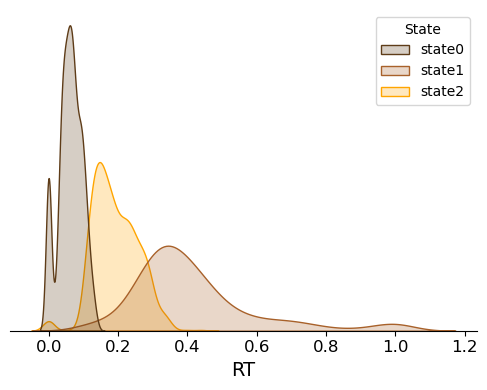

In [ ]:
# Import necessary libraries
import numpy as np
import re
import seaborn as sns
import pandas as pd
import warnings
import BehavUtils as butils
import glob
from natsort import natsorted
from sklearn.metrics import r2_score
from scipy.stats import mannwhitneyu  # Import Mann-Whitney U-test
from itertools import combinations  # For generating state pairs
import matplotlib.pyplot as plt
from collections import defaultdict  # For aggregating R² scores

# Define the number of shuffles and initialize performance arrays
numShuff = 100
perf_mouse = np.full(29, np.nan)
perf_mouse_Sh = np.full((29, numShuff), np.nan)
mouse_1 = np.array([15,16,17,18,19,20,21,22,23,24,25,26])
mouse_2 = np.array([0,1,2,3])
mouse_3 = np.array([4,5,6,7,27,28])
mouse_4 = np.array([8,9,10])
mouse_5 = np.array([11,12])
mouse_6 = np.setdiff1d(np.arange(29), np.concatenate([mouse_1, mouse_2, mouse_3, mouse_4, mouse_5]))

# Organize mouse sessions into a dictionary for easy access
mouse_sessions = {
    'mouse_1': mouse_1,
    'mouse_2': mouse_2,
    'mouse_3': mouse_3,
    'mouse_4': mouse_4,
    'mouse_5': mouse_5,
    'mouse_6': mouse_6
}

# Initialize dictionaries to store training and testing data for each mouse
mouse_data = {
    mouse: {
        'dat_train_list': [],
        'dat_test_list': [],
        'y_train_list': [],
        'y_test_list': []
    } for mouse in mouse_sessions
}

# Define mouse_labels based on your mouse_sessions dictionary
# Assuming 'mouse_sessions' is already defined as per your earlier script
mouse_labels = list(mouse_sessions.keys())

# Glob to find all relevant result files, sorted naturally
result_filename = natsorted(glob.glob(f"Results/Mouse/Results_Test_MSLR_Optuna_mouse_3states_leave_one_out_14112024_RT_AllSubjects_*_session*.npz", recursive=True))

# Initialize dictionaries to collect conditioned emissions and A-statistics
y_test_per_state = defaultdict(list)  # To store emissions per state across all sessions
a_stats = defaultdict(list)           # To store A-statistics per state pair across all sessions
# Initialize list to store conditioned emissions for each session
all_sessions_emissions = []

# Function to compute A-statistic using Mann-Whitney U-test
def compute_a_statistic(x, y):
    if len(x) == 0 or len(y) == 0:
        return np.nan  # Return NaN if one of the distributions is empty
    u_stat, _ = mannwhitneyu(x, y, alternative='two-sided')
    a_stat = u_stat / (len(x) * len(y))
    return a_stat

# Iterate over each result file (each session)
for i, file in enumerate(result_filename):
    a = np.load(file, allow_pickle=True)

    y_test = np.array(a[a.files[0]][()]['y_test'])[:,0]
    preds = np.array(a[a.files[0]][()]['predictions'])[:,0]
    states = np.argmax(np.array(a[a.files[0]][()]['most_likely_states']), axis = 1)
    preds[preds < 0] = 0

    perf_mouse[i] = r2_score(y_test, preds)
    for s in np.arange(numShuff):
        perf_mouse_Sh[i, s] = r2_score(y_test, np.random.permutation(y_test))

    # --------------------------------------------
    # ----- Compute Conditioned Emissions --------
    # --------------------------------------------

    # Identify unique states in the current session
    unique_states = np.unique(states)

    # Generate all possible pairs of states for comparison (if needed)
    state_pairs = list(combinations(unique_states, 2))

    # Iterate over each state to collect emissions
    for state in unique_states:
        emissions = y_test[states == state]
        y_test_per_state[f'state{state}'].extend(emissions)

    # Compute A-statistic for each pair of states (if needed)
    for pair in state_pairs:
        state1, state2 = pair
        emissions1 = y_test[states == state1]
        emissions2 = y_test[states == state2]
        a_stat = compute_a_statistic(emissions1, emissions2)
        a_stats[f'state{state1}_state{state2}'].append(a_stat)

    # ----------------------------------------
    # ----- Collect Conditioned Emissions -----
    # ----------------------------------------

    # Create a DataFrame for the current session
    df_session = pd.DataFrame({
        'State': states,
        'Emission': y_test
    })

    # Ensure 'Emission' is numeric, coercing errors to NaN
    df_session['Emission'] = pd.to_numeric(df_session['Emission'], errors='coerce')

    # Drop rows with NaN in 'Emission'
    #df_session = df_session.dropna(subset=['Emission'])

    # Extract session number from filename for labeling
    match = re.search(r'session(\d+)', file, re.IGNORECASE)
    if match:
        session_num = int(match.group(1))
    else:
        session_num = i + 1  # Fallback to loop index if pattern not found
    
    # Add session identifier to the DataFrame (optional). Assign corrected session number (1-based)
    df_session['Session'] = f'Session {i}'

    # Append the session DataFrame to the list
    all_sessions_emissions.append(df_session)

    # Optional: Print progress every 5 sessions
    if (i + 1) % 5 == 0 or (i + 1) == len(result_filename):
        print(f'Processed {i + 1}/{len(result_filename)} sessions.')

# ----------------------------------------
# ----- Plot Conditioned Distributions ----
# ----------------------------------------

# Convert y_test_per_state to a DataFrame for plotting
data = []
for state, emissions in y_test_per_state.items():
    for emission in emissions:
        data.append({'State': state, 'Emission': emission})
df_emissions = pd.DataFrame(data)

# Plot the conditioned distributions using Seaborn's KDE plots
cols_mouse = sns.color_palette(np.array(["#5E3C18", "#A8612A", 
                                         'orange']))

plt.figure(figsize=(5,4))
sns.kdeplot(data=df_emissions, x='Emission', hue='State', fill=True, common_norm=False, palette=cols_mouse)
plt.xlabel('RT', fontsize = 14)
plt.ylabel('', fontsize = 14)
plt.yticks([])
plt.xticks(fontsize = 12)
sns.despine(left = True)
plt.tight_layout()

/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


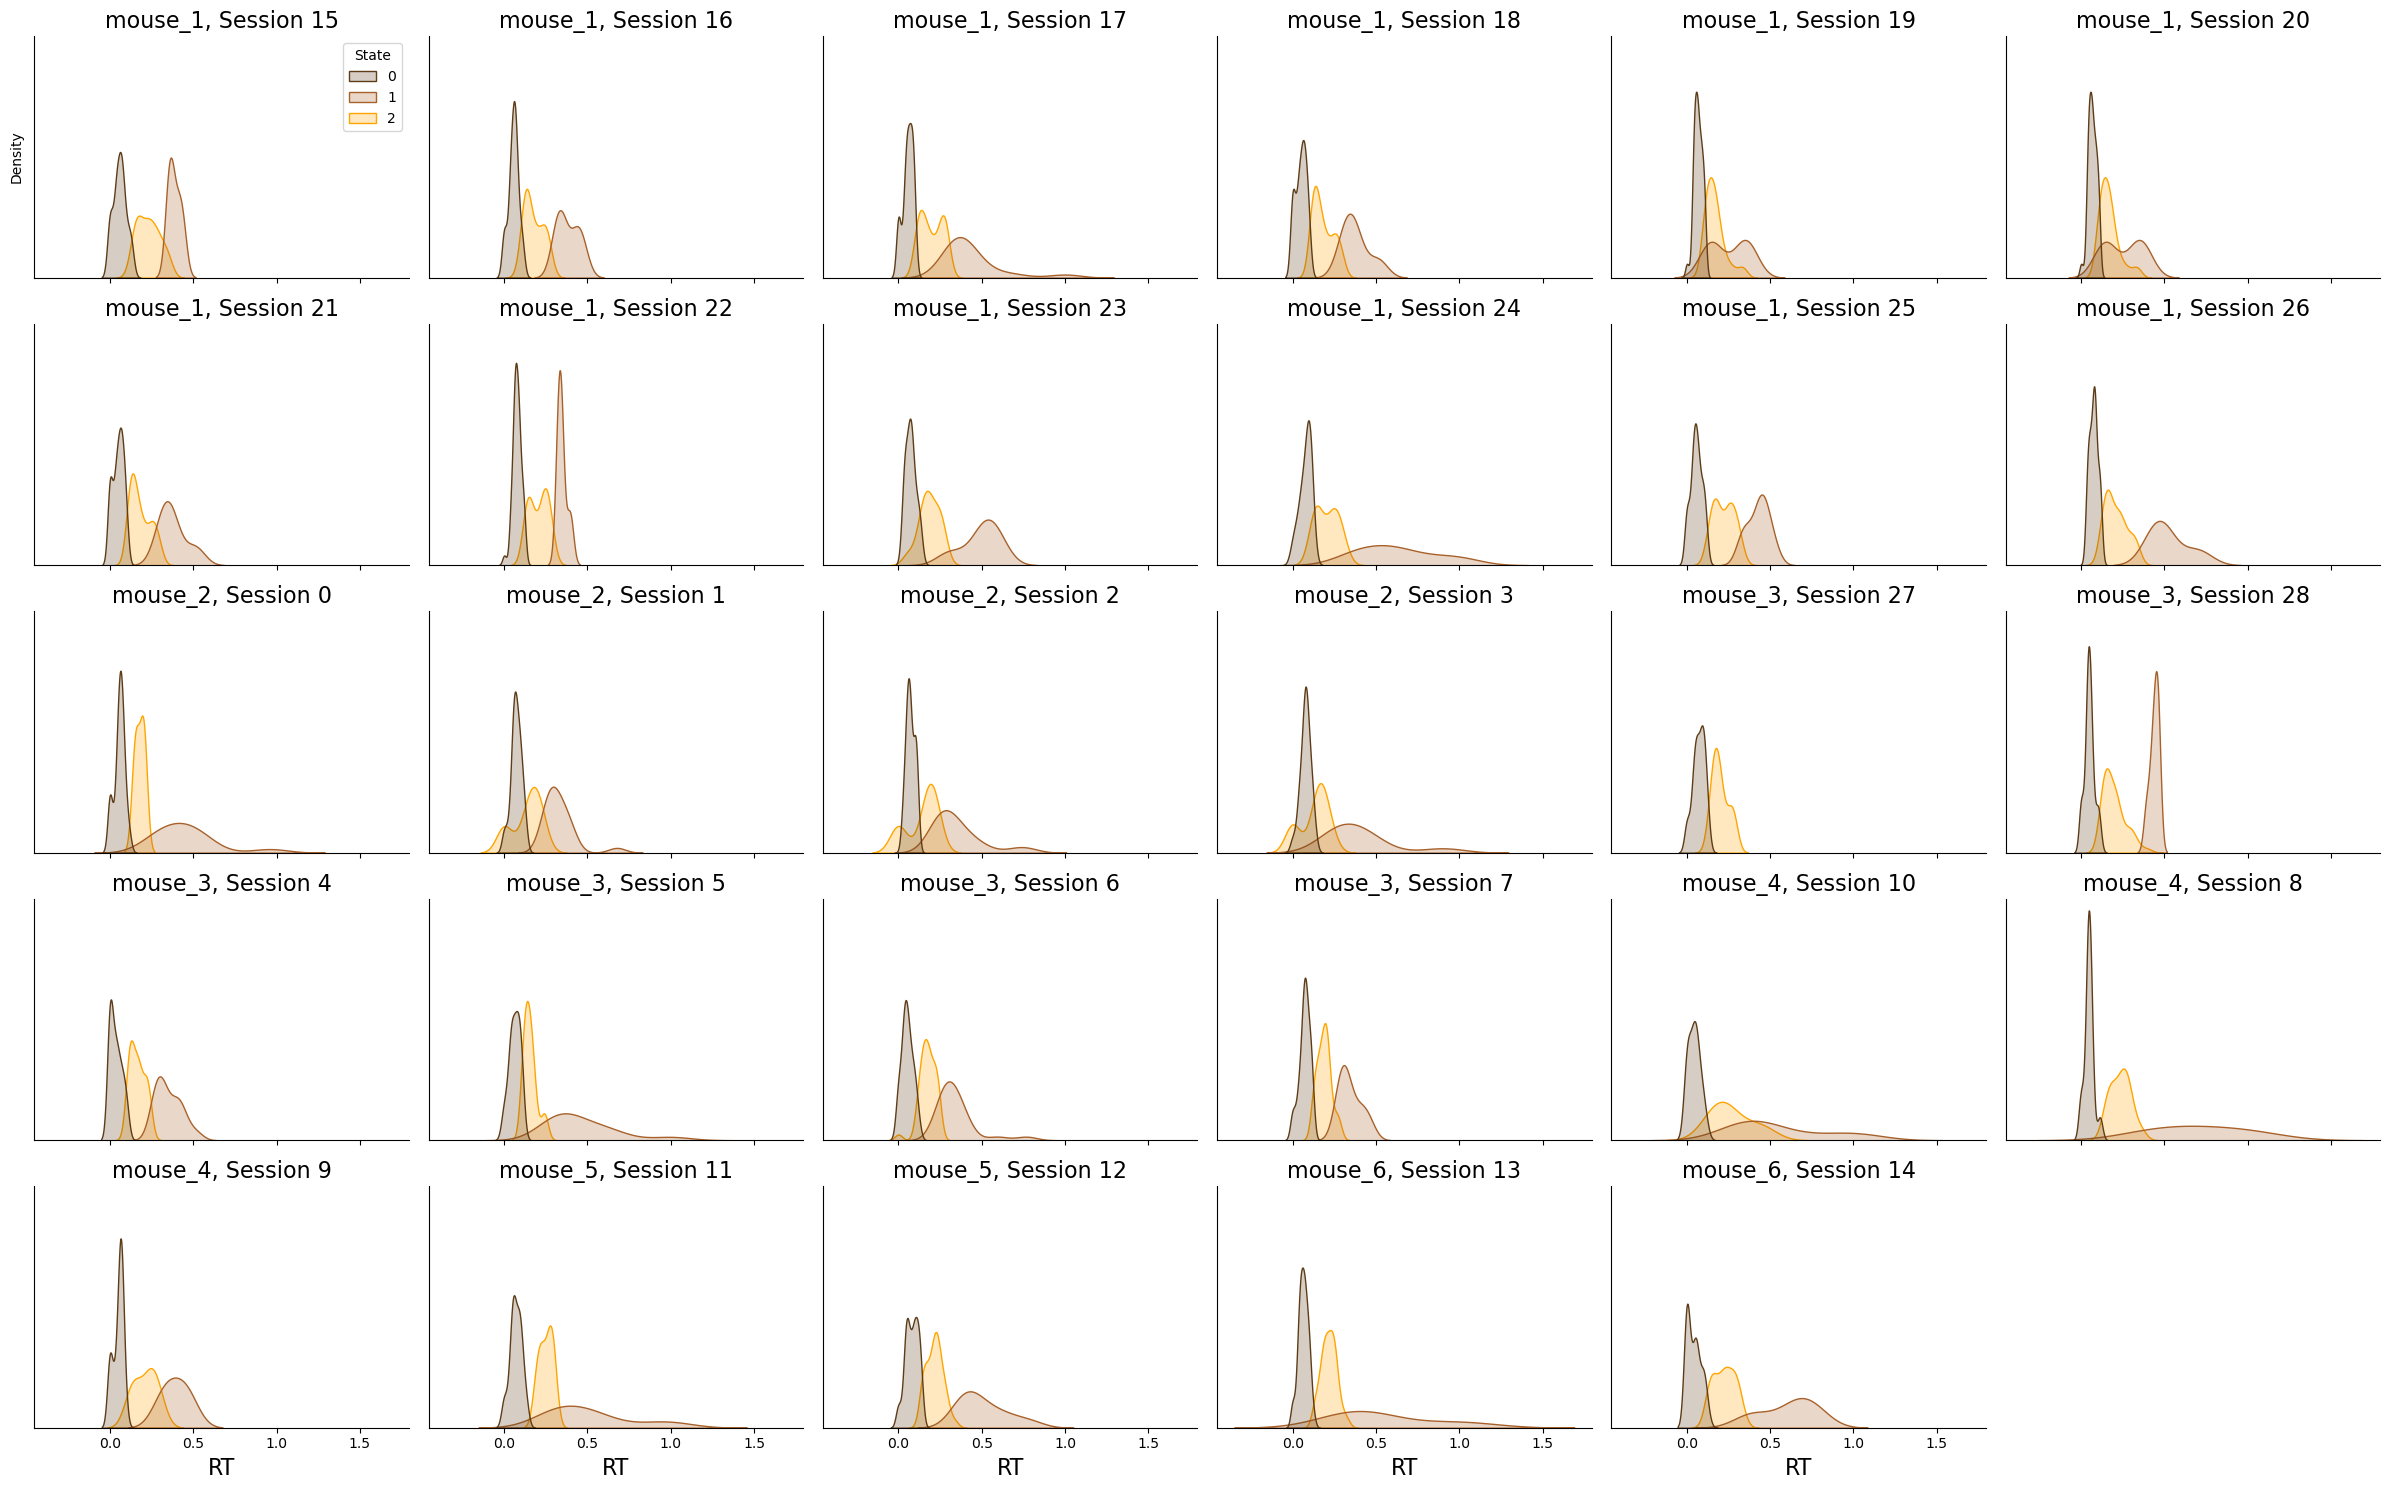

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
# Determine the number of sessions
num_sessions = len(all_sessions_emissions)  # Should be 29

# Define subplot grid dimensions (e.g., 5 rows x 6 columns for 30 subplots)
n_rows = 5
n_cols = 6

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each session and plot its conditioned distributions
for idx, df_session in enumerate(all_sessions_emissions):
    ax = axes[idx]
    
    # Extract session label and mouse ID
    session_label = df_session['Session'].iloc[0]
    mouse_id = df_session['Mouse'].iloc[0]
    
    # Plot KDE for each state within the session
    sns.kdeplot(
        data=df_session, 
        x='Emission', 
        hue='State', 
        fill=True, 
        common_norm=False, 
        palette=cols_mouse,  # Replace with 'cols_mouse' if defined
        ax=ax
    )
    
    # Set subplot title with mouse ID and session number
    ax.set_title(mouse_id +', '+ session_label, fontsize = 16)
    
    # Set labels (only on outer subplots to avoid clutter)
    if idx % n_cols == 0:
        ax.set_ylabel('Density')
    else:
        ax.set_ylabel('')
    
    if idx >= (n_rows - 1) * n_cols:
        ax.set_xlabel('RT', fontsize = 16)
    else:
        ax.set_xlabel('')
    ax.set_yticks([])
    # Remove individual legends to avoid repetition
    if idx:
        ax.get_legend().remove()

# Remove any unused subplots (e.g., the 30th subplot)
for j in range(idx + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
sns.despine()

# Save the plot with dynamic date inclusion
date = datetime.now().strftime('%d%m%Y')
plot_save_path = f"Results/Mouse/Emissions_Conditioned_Distributions_per_Session_{date}.png"
plt.savefig(plot_save_path, dpi = 300)


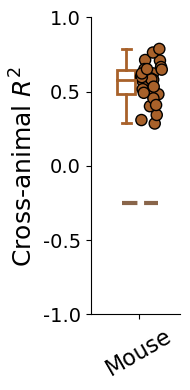

In [ ]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(2,4))
sns.despine()
cus_pal = sns.color_palette(['#7899c2ff', '#A8612A'][::-1])

sns.boxplot(data = perf_mouse, palette = cus_pal ,showfliers = False, width=0.25, linewidth = 2)

for i, artist in enumerate(ax.patches):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        artist.set_edgecolor(cus_pal[i])
        artist.set_facecolor('None')
        # Each box has 5 associated Line2D objects (because there are no outliers)
        # Loop over them here, and use the same colour as above
        for j in range(i*5,i*5+5):
            line = ax.lines[j]
            line.set_color(cus_pal[i])
            line.set_lw(2)
            line.set_mfc(cus_pal[i])
            line.set_mec(cus_pal[i])


sns.stripplot(data=perf_mouse, palette=cus_pal, jitter=0.15, alpha=1, edgecolor='black', linewidth=1, ax=ax, zorder = 1, dodge=False, size = 8)

# adjust x-limits to make room for stripplot
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + 0.25)
# shift the stripplot to the right
for line in ax.collections:
    x, y = line.get_offsets().T
    line.set_offsets(np.c_[x + 0.35, y])
    
ax.set_xticks(ticks = [0.1775], labels = ['Mouse'], fontsize = 16, rotation = 30)
#ax.set_yticks(ticks = np.linspace(-1., 1, 5), labels = ['{:.1f}'.format(a) for a in np.linspace(-1., 1, 5)], fontsize = 14)
ax.set_yticks(ticks = np.linspace(-1, 1, 5), labels = ['{:.1f}'.format(a) for a in np.linspace(-1, 1, 5)], fontsize = 14)
ax.set_ylabel('Cross-animal $R^2$', fontsize = 18)
plt.axhline(np.percentile(perf_mouse_Sh,99), xmin = 0.35, xmax = 0.75, color = sns.desaturate('#A8612A',0.5), lw = 3, ls = '--')
plt.tight_layout()
#plt.savefig('Results/BothSpecies_AllSubjects_R2_Test_RT_27022024.svg', transparent = True)